# Simulation Experiments

$\large{\textbf{Simulating contamination in RCT and evaluating its impact on statistical power}}$

Induce contamination by changing x% of the control arm indicator to intervention. Evaluate if this approach of inducing contamination agrees with the closed-form formula.

In [1]:
tab_fig_path='/burg/biostats/users/ek3235/RCTcontamination/contamiation_in_rct/tables_and_figures/'

In [2]:
library(ggplot2)
library(gridExtra)
library(tidyr) # for reshaping to long format. 
library(lme4)
library(svglite) # save plot in svg format. 
library(parallel)
library(doParallel)

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loading required package: foreach

Loading required package: iterators



In [3]:
# Calculate the required sample size for a fixed effect 

#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
#+Functions from Stuart J Pocock's book - Clinical Trials (2013)
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#

# f(alpha, beta) function from Stuart J. Pocock 
f.alpha.beta=function(type_I_error, type_II_error){
  
  zbeta=qnorm(type_II_error, lower.tail=FALSE)
  zalpha=qnorm(type_I_error/2, lower.tail=FALSE)
  
  f_ab=(zbeta+zalpha)^2
  
  return(f_ab)
  
}

# results match those from Stuart's book. 
f.alpha.beta(type_I_error=0.1,
     type_II_error=0.05)


# sample size formula for continuous outcome
cont.sample.size=function(m1,
                          m2,
                          sd,
                          type_I_error, 
                          type_II_error){
  
  t1=( 2*sd^2)/(m1-m2)^2 # first term as t1
  
  f_ab=f.alpha.beta(type_I_error=type_I_error,
                         type_II_error=type_II_error)
  n=ceiling(t1*f_ab)
  
  return(n)
  
}

# results agree with the ones from Pocock's book. 
cont.sample.size(m1=9.0,
                 m2=9.5,
                 sd=1.8,
                 type_I_error=0.05, 
                 type_II_error=0.05)

[1] 10.82217

[1] 337

In [4]:
# Sample size required to detect a difference of 0.2 assuming standard deviation of 1, type I error of 0.05, power of 0.8 <==> type II error of 0.2.
# Note that m1 and m2 corresponds to group 1 and 2 means respectively. Although it is important to point out that the magnitude of m1 and m2 do not matter in sample size calculation.
# It matters only when we want to communicate the right context for our experiment. What is important is the difference we want to detect (i.e., |m1-m2|). 

n.group1=cont.sample.size(
                m1=1.0,
                m2=1.2,
                sd=1,
                type_I_error=0.05, 
                type_II_error=0.2)

total.n=ceiling(n.group1*2)
total.n # total sample size


[1] 786

In [5]:
# Evaluate if simulated-based power calculation agree with closed-form formula. 

beta=0.2
n=total.n

trt=rbinom(n,size=1, prob=0.5)
#table(trt)

xb=beta*trt


betahat=NULL
signif=NULL
for ( i in 1:1000){
    y=rnorm(n=n, mean=xb)

    data1=data.frame(y=y, trt=trt)

    model1=lm(y~trt,data=data1)

    betahat[i]=summary(model1)$coeff['trt', 'Estimate']
    signif[i]=summary(model1)$coeff['trt','Pr(>|t|)']<0.05
}


# The estimate power is close to the 'true' power!
pwr=round( sum(signif)/length(signif) , 2)

# Open a pdf or svg file and save histogram plot. 
# This is important for initial exploration of the data. 
svglite(paste0(tab_fig_path,"betahat_distr.svg") )

hist(betahat, main='')
abline(v=beta, col='green', lwd=7, lty=3)
abline(v=mean(betahat), col='blue', lwd=7, lty=3)
legend('topright', legend= paste0('power= ', pwr) )

dev.off() # make sure to close file. 

# It seems to agree! Note that power is a random variable in this case. So, to improve on confidence of the results, one can try to obtain coverage probabilities. 
#ggsave(file=paste0(tab_fig_path,"betahat_dist_without_contamination.svg"), plot=p1, width=10, height=5 )

png 
  2

$\large{\textbf{Induce contamination and examine its impact on the statitical power.}}$

There are two possible ways to induce contamination. 
   1. Simulate y and then change $x\%$ of the control arm to intervention indicator. 
   2. Simulate trt variable such that $prob(trt=1)=0.5+\%x$. Use this trt variable to simulate y. Change $x\%$ in trt==1 to trt==0. That way, we have $x\%$ of control arm who gained intervention benefits. 
   
I am inclined to trust option 2 as opposed to option 1. Option 1 does not directly induce intervention response to control arm. But in any case, I will try both and check how they
affect power. 


$\small{\textbf{Option 1: Simulate y and then change x% of the control arm to intervention indicator}}$

In [6]:
beta=0.2
n=total.n
contam.rate=0.3

trt=rbinom(n,size=1, prob=0.5)

trt.contam=trt # create a new trt object and induce contamination according to option 1

trt.contam[trt==0]=trt.contam[trt==0]+ rbinom(n=sum(trt==0), prob=contam.rate, size=1)

xb=beta*trt.contam

betahat=NULL
signif=NULL
for ( i in 1:1000){
    
    y=rnorm(n=n, mean=xb) # make sure that x=trt.contam variable contamination is acting on the background.
    
    data1=data.frame(y=y, trt=trt) # make sure to use trt variable here since that is what we have access to. 

    model1=lm(y~trt,data=data1)

    betahat[i]=summary(model1)$coeff['trt', 'Estimate']
    
    signif[i]=summary(model1)$coeff['trt','Pr(>|t|)']<0.05
}

# The estimate power is close to the 'true' power!
pwr=round( sum(signif)/length(signif) , 2)

svglite(paste0(tab_fig_path,"betahat_distr_with_contam.svg") )

hist(betahat, main=paste0('option 1 : contamination rate = ',contam.rate ))
abline(v=beta, col='green', lwd=7, lty=3)
abline(v=mean(betahat), col='blue', lwd=7, lty=3)

legend('topright', legend=c(paste0('est power= ', pwr),
                           'exp beta', 'true beta' ), col=c('white', 'blue', 'green' ), lty=3, lwd=7 )

dev.off()

# the estimated treatment effect is very close to what we would expect under this contamination rate. 

png 
  2

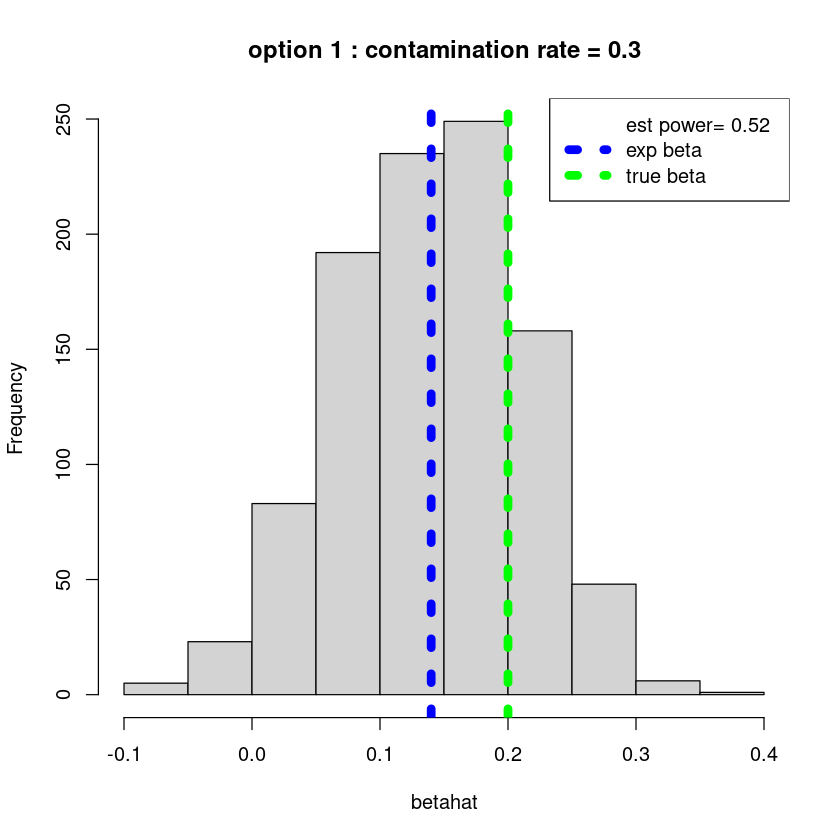

In [7]:
hist(betahat, main=paste0('option 1 : contamination rate = ',contam.rate ))
abline(v=beta, col='green', lwd=7, lty=3)
abline(v=mean(betahat), col='blue', lwd=7, lty=3)

legend('topright', legend=c(paste0('est power= ', pwr),
                           'exp beta', 'true beta' ), col=c('white', 'blue', 'green' ), lty=3, lwd=7 )


$\textbf{Statistical power when we have a fixed sample size with or without contamination}$

In [19]:
# Statistical power when we have a fixed sample size. Invert sample size formula to get beta then take 1-beta for power. 

pwr.func=function(n, 
                  m1,
                  m2,
                  sd,
                  type_I_error, 
                 contamin.rate=NULL){
    
    # note that contamination rate must be between 0 and 1. 
    
    if (!is.null(contamin.rate)){
        
        d=(1-contamin.rate)*abs(m1-m2)
    }else{
        d=abs(m1-m2)
    }
    
    zalpha=qnorm(type_I_error/2, lower.tail=FALSE)
    
    t1=zalpha-(sqrt(n/2)*(d/sd)) 
    
    pwr=1-pnorm(t1) #power since t1 is z_{1-beta}
    
    return(pwr)
    

}



n.group1=cont.sample.size(
                m1=1.0,
                m2=1.2,
                sd=1,
                type_I_error=0.05, 
                type_II_error=0.2)


# the power function is working properly! 
pwr.func(n=n.group1, 
        m1=1.0,
        m2=1.2,
        sd=1,
        type_I_error=0.05)



# with contamination. The results here seem to agree with what we have in the simulation based on contamination by option 1. 
pwr.func(n=n.group1, 
        m1=1.0,
        m2=1.2,
        sd=1,
        type_I_error=0.05, 
        contamin.rate=0.3)

[1] 0.800555

[1] 0.5010111

In [23]:
pwr.func(n=500, 
        m1=1.0,
        m2=1.2,
        sd=1,
        type_I_error=0.05)

[1] 0.885379

$\textbf{Simulate trt variable such that}$ $prob(trt=1)=0.5+ \%x$ $\textbf{Use this trt variable to simulate y}$

Change $x\%$ in trt==1 to trt==0. That way, we have $x\%$ of control arm who gained intervention benefits.

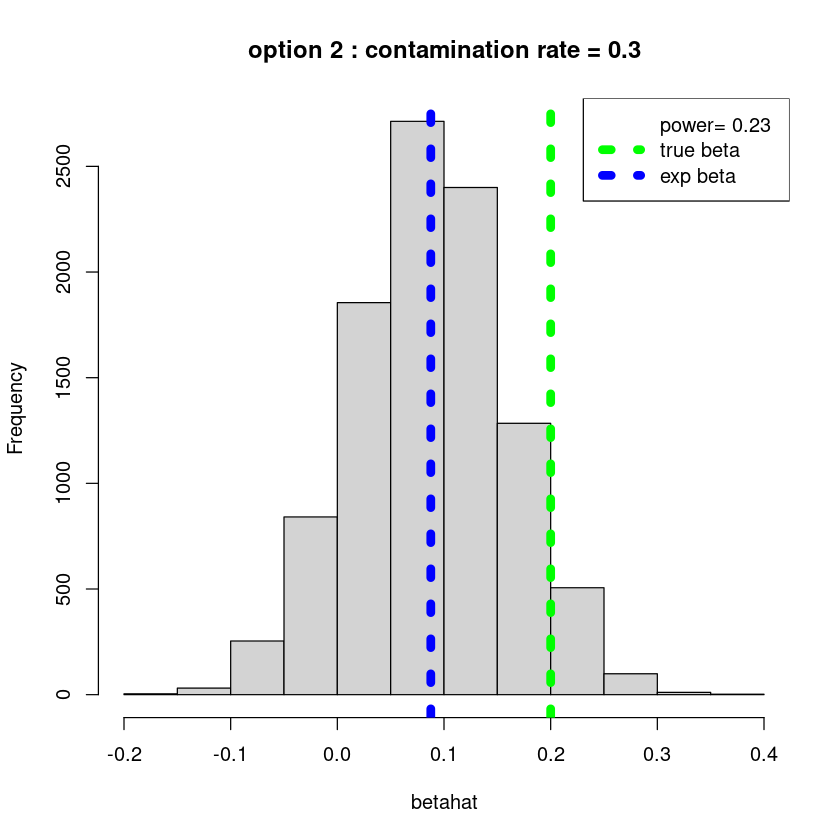

In [12]:
beta=0.2
n=total.n
contam.rate=0.3 

trt=rbinom(n=n,size=1, prob=0.5+contam.rate) # make sure to add contamination rate. 

#table(trt)/total.n

trt.contam=trt # create a new trt object and induce contamination according to option 1

trt.contam[trt==1]=trt.contam[trt==1] - rbinom(n=sum(trt==1), prob=contam.rate, size=1) # change %x of trt==1 to trt==0

#table(trt.contam)/total.n

xb=beta*trt # again, use the trt variable that is already contaminated since this is the variable we expect to be acting in the background. 

betahat=NULL
signif=NULL
for ( i in 1:10000){
    
    y=rnorm(n=n, mean=xb)
    
    data1=data.frame(y=y, trt=trt.contam) # make sure to use trt variable here since this is what we have access to in reality. 

    model1=lm(y~trt,data=data1)

    betahat[i]=summary(model1)$coeff['trt', 'Estimate']
    signif[i]=summary(model1)$coeff['trt','Pr(>|t|)']<0.05
}


hist(betahat, main=paste0('option 2 : contamination rate = ', contam.rate))
abline(v=beta, col='green', lwd=7, lty=3)
abline(v=mean(betahat), col='blue', lwd=7, lty=3)

# The estimate power is close to the 'true' power!
pwr=round( sum(signif)/length(signif) , 2)

legend('topright', legend=c( paste0('power= ', pwr),
                           'true beta', 'exp beta'), col=c('white', 'green', 'blue' ), lty=3, lwd=7 )

# Again, the power seems to agree with the one from closed form formula! 
# The question is, 'which option of contamination is correct?' 
# Option 2, which seems logically reasonable actually disagrees with the estimate power when contamination rate increases. 

# Remember to ask Profs Cheng and Min which option is correct. 

In [13]:
# Possible directions from here 
#1. Power vs contamination rate for a fixed sample size 
#2. Power vs contamination rate for different sample sizes adjusted for the contamination. That is, the sample sizes are calculated based on the attenuated treatment effect. 
    # Here, I expect the power not to change that much! 
#3. Simulate data from a mixed effects model (cluster=doctors). See how the variance in cluster affects power? That is, include doctor's effect and see how that affects
    # power. (ToDo: Think more about how this approach is addressing my current research question(s).) It maybe safe to ignore it for now. 
#4. Estimate treatment effect in the presence of contamination where compliance information is available. 
        #One strategy is to include complaince variable in the design matrix. 
        #The other is to adjust sample size calculation during the design stage of the trial. Of course,we need to know what contamination level to use with aim of avoiding 
        # unnecessary increase in sample size. 

#5. Evaluate critical rate for which individual randomization loses its efficiecy against cluster randomization. Here, the goal is to reproduce results in 
# the paper ' Contamination: Howmuch can an individually randomized trial tolerate?', Figure 2. And then provide a clear interpretation of the results. 


$\textbf{Power vs contamination rate for a fixed sample size using}$ $\underline{\text{option 1}}$ $\textbf{method of contamination}$

In [14]:
n.group1=cont.sample.size(
                m1=1.0,
                m2=1.2,
                sd=1,
                type_I_error=0.05, 
                type_II_error=0.2)

total.n=n.group1*2

beta=0.2
n=total.n

contam.mat=matrix( seq(0, 0.5, by=0.1), nrow=1 )

pwr.vs.contam=function(contam.rate){
    
    trt=rbinom(n,size=1, prob=0.5)

    trt.contam=trt # create a new trt object and induce contamination according to option 1

    trt.contam[trt==0]=trt.contam[trt==0]+ rbinom(n=sum(trt==0), prob=contam.rate, size=1)

    xb=beta*trt.contam # use x=trt.contam since that is the variable that acts in the background when we have contamination. 

    betahat=NULL
    signif=NULL
    for ( i in 1:1000){

        y=rnorm(n=n, mean=xb) 

        data1=data.frame(y=y, trt=trt) # make sure to use trt variable since that is what we have access to in reality. 

        model1=lm(y~trt,data=data1)

        #betahat[i]=summary(model1)$coeff['trt', 'Estimate']
        signif[i]=summary(model1)$coeff['trt','Pr(>|t|)']<0.05
    }

    # The estimate power is close to the 'true' power!
    pwr=round( sum(signif)/length(signif) , 2) 
    
    return(pwr)

}


In [15]:
est.pwr.vec=apply(X=contam.mat, MARGIN=2, FUN=pwr.vs.contam)

In [16]:
# Check the power we expect under the different contaminations using closed form formula 
true.pwr.vec=apply(X=contam.mat, MARGIN=2, FUN=function(contam.rate){
    pwr.func(n=n.group1, 
        m1=1.0,
        m2=1.2,
        sd=1,
        type_I_error=0.05, 
        contamin.rate=contam.rate)}  
                  )

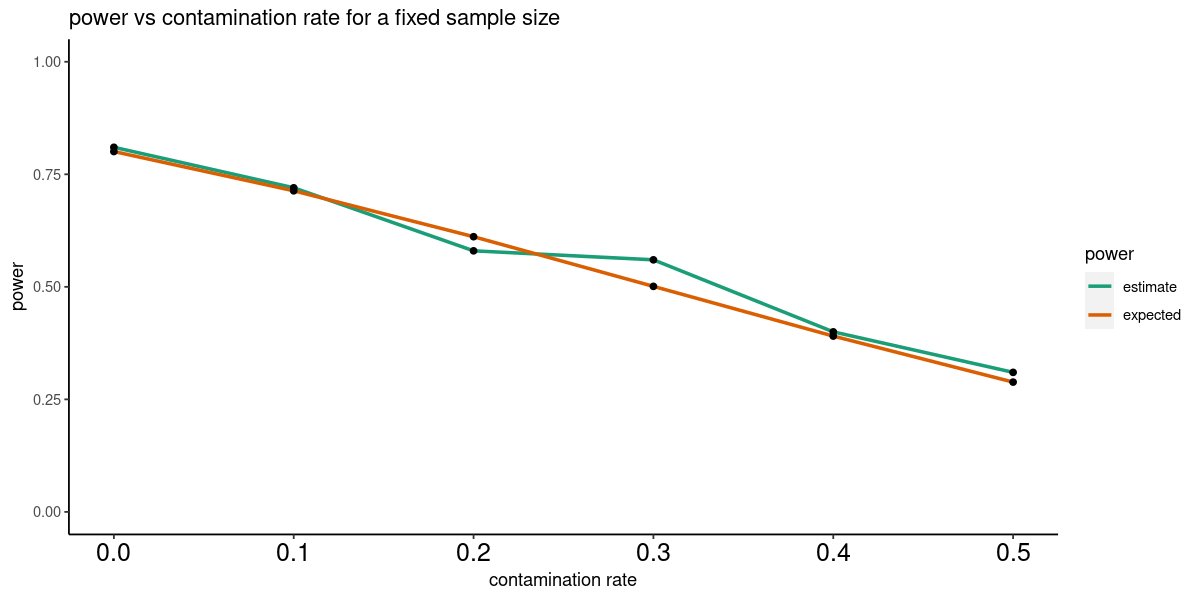

In [17]:
options(repr.plot.width = 10, repr.plot.height =5) 

# combine estimated vs true power and plot. 
est.pwr.df=data.frame(contam.rate=contam.mat[1,], pwr=est.pwr.vec, power=rep('estimate', length(est.pwr.vec) ))

true.pwr.df=data.frame(contam.rate=contam.mat[1,], pwr=true.pwr.vec, power=rep('expected', length(true.pwr.vec) ))

pwr.df=rbind(est.pwr.df, true.pwr.df)

plot1=ggplot(pwr.df, aes(x=contam.rate, y=pwr, group=power)  )+
geom_line(aes(
    color=power
), lwd=1.0)+
geom_point()+scale_color_brewer(palette="Dark2")+
ylim(0,1)+
labs(x="contamination rate",y="power")+
theme(axis.text.x = element_text(#face = "bold", 
                            color ="black", 
                           size = 15, angle = 0))+
ggtitle('power vs contamination rate for a fixed sample size')+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))

plot1

# we see that estimated vs expected power are virtually the same upto a contamination of 0.2! Why do we see this behavior? 
# The paper 'Contamination: How much can an individually randomized trial tolerate?' may provide some idea of why we see this in Figure B1 in Appendix B

$\textbf{Power vs contamination rate for a fixed sample size using}$ $\underline{\text{option 2}} $ $\textbf{method of contamination}$ 

In [94]:
n.group1=cont.sample.size(
                m1=1.0,
                m2=1.2,
                sd=1,
                type_I_error=0.05, 
                type_II_error=0.2)

n=n.group1*2 # total n 

beta=0.2

contam.mat=matrix( seq(0, 0.5, by=0.1), nrow=1 )

pwr.vs.contam.option2=function(contam.rate){
    
    trt=rbinom(n=n,size=1, prob=0.5+contam.rate) # make sure to add contamination rate. 

    #table(trt)/total.n

    trt.contam=trt # create a new trt object and remove contamination. 

    trt.contam[trt==1]=trt.contam[trt==1] - rbinom(n=sum(trt==1), prob=contam.rate, size=1) # change %x of trt==1 to trt==0
    
    #print ( paste0('Distribution of control and intervention ', table(trt.contam)*100/n ) )

    xb=beta*trt

    betahat=NULL
    
    signif=NULL
    
    for ( i in 1:1000){

        y=rnorm(n=n, mean=xb)

        data1=data.frame(y=y, trt=trt.contam) # make sure to use trt.contam variable here. 

        model1=lm(y~trt,data=data1)

        #betahat[i]=summary(model1)$coeff['trt', 'Estimate']
        signif[i]=summary(model1)$coeff['trt','Pr(>|t|)']<0.05
    }

    # The estimate power is close to the 'true' power!
    pwr=round( sum(signif)/length(signif) , 2) 
    
    return(pwr)

}

In [ ]:
est.pwr.vec=apply(X=contam.mat, MARGIN=2, FUN=pwr.vs.contam.option2)


# Check the power we expect under the different contaminations using closed form formula 
true.pwr.vec=apply(X=contam.mat, MARGIN=2, FUN=function(contam.rate){
    pwr.func(n=n.group1, 
        m1=1.0,
        m2=1.2,
        sd=1,
        type_I_error=0.05, 
        contamin.rate=contam.rate)}  
                  )

In [93]:
pwr.vs.contam.option2(contam.rate=0.3)

trt.contam
  0   1 
345 441 


[1] 0.24

In [81]:
table(rbinom(n=n,size=1, prob=0.5))


  0   1 
392 394 

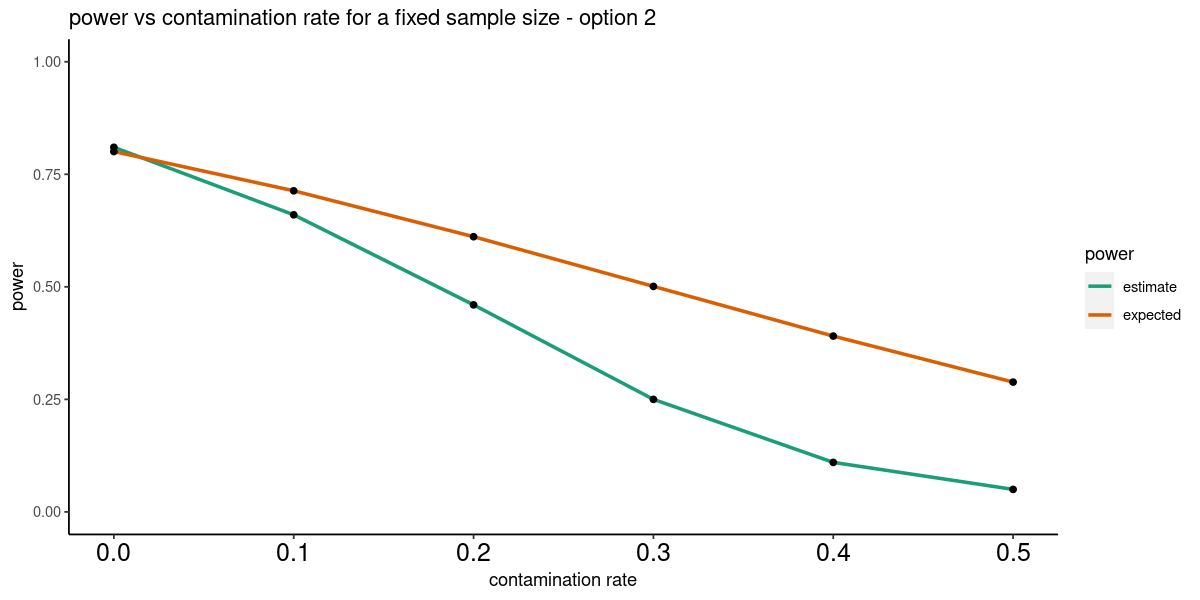

In [19]:
options(repr.plot.width = 10, repr.plot.height =5) 

# combine estimated vs true power and plot. 
est.pwr.df=data.frame(contam.rate=contam.mat[1,], pwr=est.pwr.vec, power=rep('estimate', length(est.pwr.vec) ))

true.pwr.df=data.frame(contam.rate=contam.mat[1,], pwr=true.pwr.vec, power=rep('expected', length(true.pwr.vec) ))

pwr.df=rbind(est.pwr.df, true.pwr.df)

plot2=ggplot(pwr.df, aes(x=contam.rate, y=pwr, group=power)  )+
geom_line(aes(
    color=power
), lwd=1.0)+
geom_point()+scale_color_brewer(palette="Dark2")+
ylim(0,1)+
labs(x="contamination rate",y="power")+
theme(axis.text.x = element_text(#face = "bold", 
                            color ="black", 
                           size = 15, angle = 0))+
ggtitle('power vs contamination rate for a fixed sample size - option 2')+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))

plot2

# we see that option method of inducing contamination leads to severe power loss at  increased contamination rate. This results seem to support option 1 method of 
# inducing contamination. 


$\textbf{Power vs contamination rate for different sample sizes adjusted for the contamination.}$

That is, the sample sizes are calculated based on the attenuated treatment effect. Here, I expect that the power not to change that much! 

In [28]:
pwr.vs.contam.adjust=function(contam.rate){
    
    # adjust sample size to account for the contamination rate. 
    n.group1=cont.sample.size(
                m1=1.0,
                m2=1.2,
                sd=1,
                type_I_error=0.05, 
                type_II_error=0.2)
    
    d=0.2 # m1-m2 # ToDo: Later improvement of this function for optimal functioning. 
    
    dc= (1-contam.rate)*0.2 # reduced difference due to contamination. 
    
    n.group1=n.group1*(d^2/dc^2) # adjusted sample size to account for contamination. NOTE that, I can encode this information directly to the cont.sample.size() function.
    
    n=n.group1*2 # total n
    
    trt=rbinom(n,size=1, prob=0.5)

    trt.contam=trt # create a new trt object and induce contamination according to option 1

    trt.contam[trt==0]=trt.contam[trt==0]+ rbinom(n=sum(trt==0), prob=contam.rate, size=1)

    xb=beta*trt.contam

    betahat=NULL
    signif=NULL
    for ( i in 1:10000){

        y=rnorm(n=n, mean=xb)

        data1=data.frame(y=y, trt=trt) # make sure to use trt.contam variable here. 

        model1=lm(y~trt,data=data1)

        #betahat[i]=summary(model1)$coeff['trt', 'Estimate']
        signif[i]=summary(model1)$coeff['trt','Pr(>|t|)']<0.05
    }

    # The estimate power is close to the 'true' power!
    pwr=round( sum(signif)/length(signif) , 2) 
    
    return(pwr)

}

In [29]:
pwr.vs.contam.adjust(0.5)

[1] 0.78

In [30]:
est.pwr.vec.adjust=apply(X=contam.mat, MARGIN=2, FUN=pwr.vs.contam.adjust)

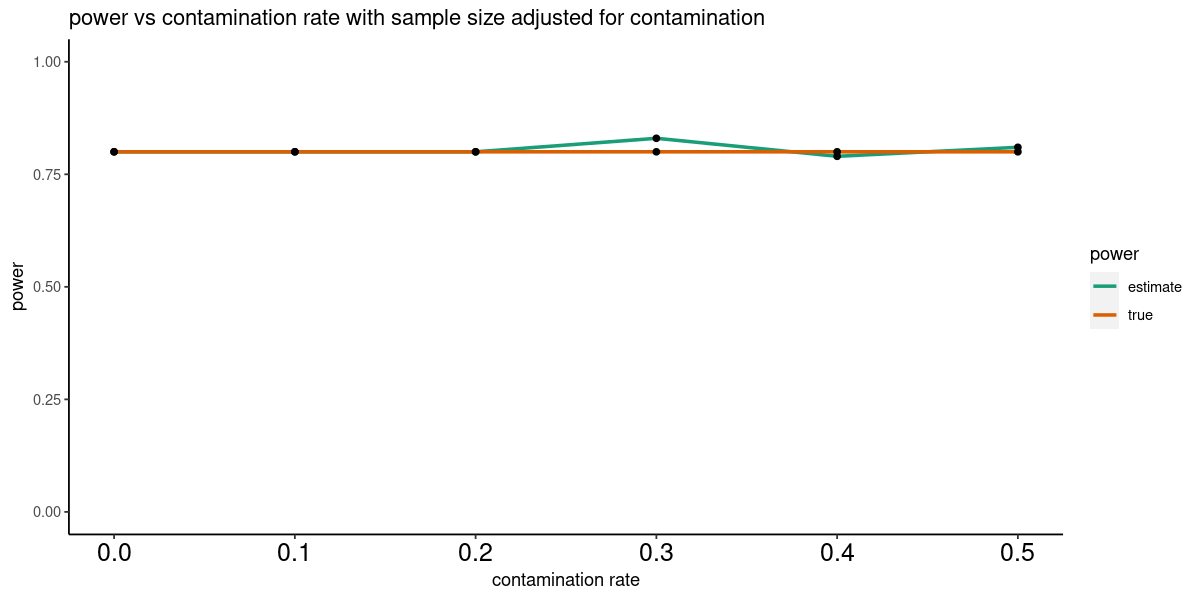

In [31]:
options(repr.plot.width = 10, repr.plot.height =5) 

# combine estimated vs true power and plot. 
est.pwr.adjust.df=data.frame(contam.rate=contam.mat[1,], pwr=est.pwr.vec.adjust, power=rep('estimate', length(est.pwr.vec.adjust) ))

true.pwr.df=data.frame(contam.rate=contam.mat[1,], pwr=rep(0.8, length(est.pwr.vec.adjust) ), power=rep('true', length(true.pwr.vec) ))

pwr.df=rbind(est.pwr.adjust.df, true.pwr.df)

plot3=ggplot(pwr.df, aes(x=contam.rate, y=pwr, group=power)  )+
geom_line(aes(
    color=power
), lwd=1.0)+
geom_point()+scale_color_brewer(palette="Dark2")+
ylim(0,1)+
labs(x="contamination rate",y="power")+
theme(axis.text.x = element_text(#face = "bold", 
                            color ="black", 
                           size = 15, angle = 0))+
ggtitle('power vs contamination rate with sample size adjusted for contamination')+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))

plot3

#save
plot1.3= arrangeGrob(plot1,plot3, nrow = 1) #generates g

ggsave(file=paste0(tab_fig_path,"power_vs_contamination.svg"), plot=plot1.3, width=15, height=5 )


# We see that adjusting sample size for contamination allows us to protect against any power loss during estimation of treatment effect. 
# Unfortunately, this approach leads to excessive sample than is actually needed. 
#Here, I used adjustment method as suggested in 'Contamination in trials: is cluster randomisation the answer?' Is there a better method of adjustment such at the sample is just about 
# right to give the expected power? 
# It is also important to remember that the estimated power itself is random. So, maybe adding some confidence band may tell us whether we are always within the expected power. 

# ToDo: Examine sample size as function of contamination rate. Plot it against power plot. Discuss whether the increase in sample size is worth the trouble. 

In [32]:
# Sample size as a function of contamination rate. 

sample.size.contam.adjust=function(contam.rate){
    
    # adjust sample size to account for the contamination rate. 
    n.group1=cont.sample.size(
                m1=1.0,
                m2=1.2,
                sd=1,
                type_I_error=0.05, 
                type_II_error=0.2)
    
    d=0.2 # m1-m2 # ToDo: Later improvement of this function for optimal functioning. 
    
    dc= (1-contam.rate)*0.2 # reduced difference due to contamination. 
    
    n.group1=n.group1*(d^2/dc^2) # adjusted sample size to account for contamination. NOTE that, I can encode this information directly to the cont.sample.size() function.
    
    n=n.group1*2 # total n
    
    return(n)

}
    
sample.size.adjust=apply(X=contam.mat, MARGIN=2, FUN=sample.size.contam.adjust)


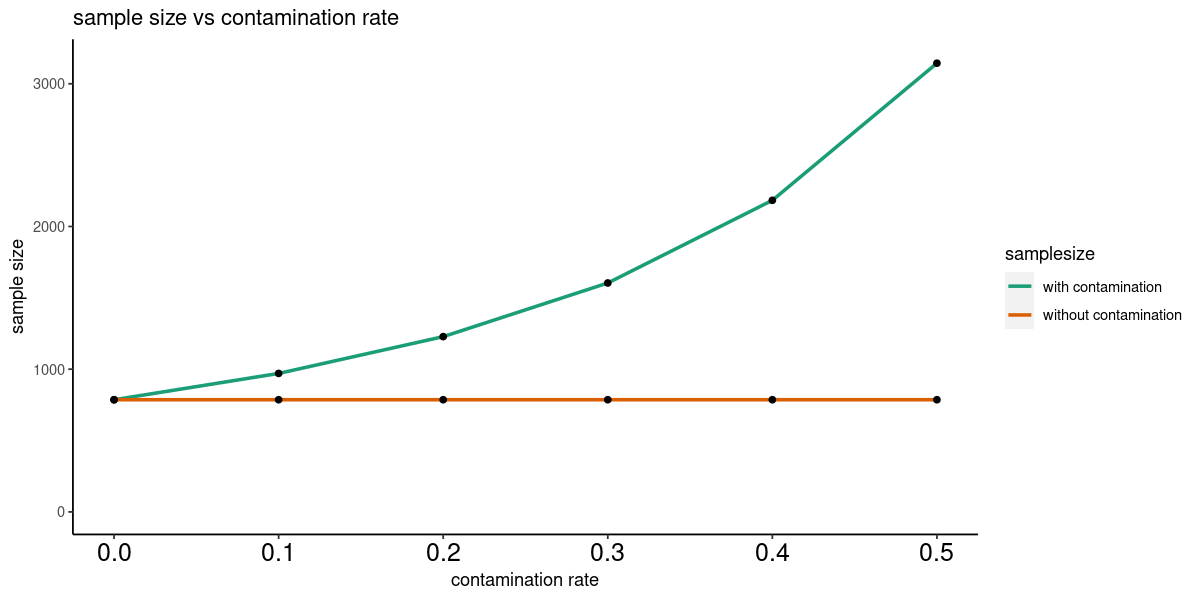

In [33]:
options(repr.plot.width = 10, repr.plot.height =5) 

# combine estimated vs true power and plot. 
sample.size.adjust.df=data.frame(contam.rate=contam.mat[1,], n=sample.size.adjust, samplesize=rep('with contamination', length(sample.size.adjust) ))

true.sample.df=data.frame(contam.rate=contam.mat[1,], n=rep(sample.size.adjust[1], length(sample.size.adjust) ), samplesize=rep('without contamination', length(sample.size.adjust) ))

samplesize.df=rbind(sample.size.adjust.df, true.sample.df)

plot4=ggplot(samplesize.df, aes(x=contam.rate, y=n, group=samplesize)  )+
geom_line(aes(
    color=samplesize
), lwd=1.0)+
geom_point()+scale_color_brewer(palette="Dark2")+
ylim(0,max(sample.size.adjust)+10)+
labs(x="contamination rate",y="sample size")+
theme(axis.text.x = element_text(#face = "bold", 
                            color ="black", 
                           size = 15, angle = 0))+
ggtitle('sample size vs contamination rate')+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))

plot4

# The sample size increase is exponetial. Not a good deal considering how expensive and time consuming it is to run large trials. 

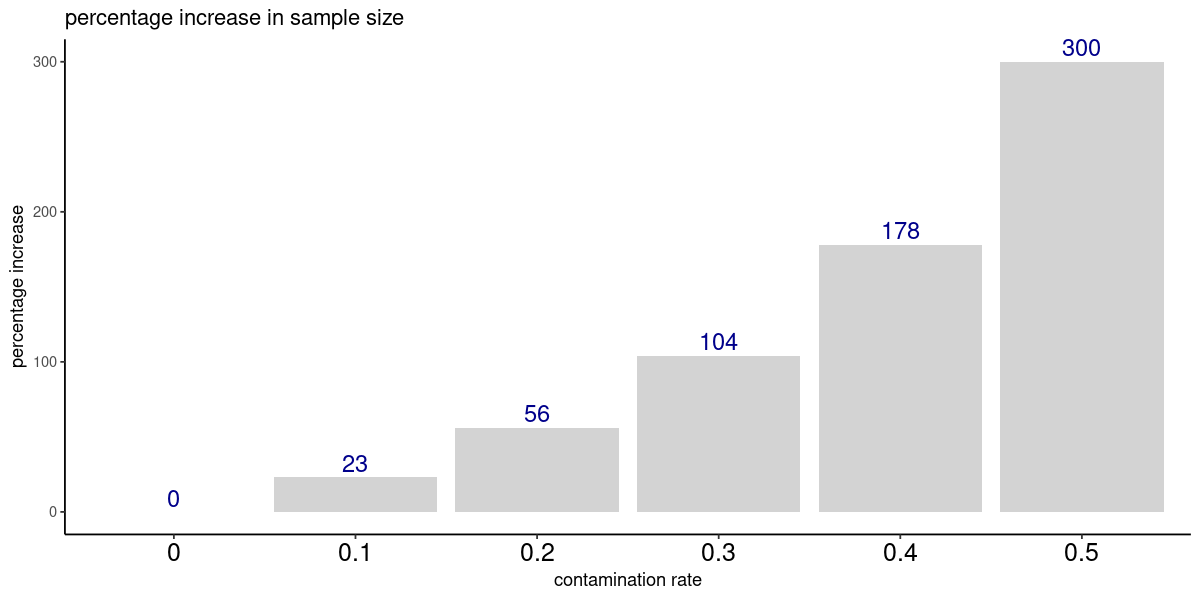

In [34]:
# Plot percentage icnrease in sample size with contamination rate. 
options(repr.plot.width = 10, repr.plot.height =5) 

sample.size.adjust.df$percentage.increase=round ( (sample.size.adjust.df$n-sample.size.adjust.df$n[1])/sample.size.adjust.df$n[1], 2)*100

plot5=ggplot(sample.size.adjust.df, aes(x=as.factor(contam.rate), y=percentage.increase)  )+
geom_bar(stat="identity", fill="lightgrey")+
labs(x="contamination rate",y="percentage increase")+
geom_text(aes(label=percentage.increase), vjust=-0.3, size=5, color='blue4')+
theme(axis.text.x = element_text(#face = "bold", 
                            color ="black", 
                           size = 15, angle = 0))+
ggtitle('percentage increase in sample size')+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))

plot5


#save
plot4.5= arrangeGrob(plot4,plot5, nrow = 1) #generates g

ggsave(file=paste0(tab_fig_path,"samplesize_vs_contamination.svg"), plot=plot4.5, width=15, height=5 )

Standard Normal Density Plot

In [28]:
set.seed(12)
xdf=data.frame(x=rnorm(100000))

options(repr.plot.width = 10, repr.plot.height =5) 
plt.dens=ggplot(data=xdf, aes(x=x))+
geom_density(color="black", lwd=1.2)+
theme(axis.text.x = element_text(#face = "bold", 
                            color ="black", 
                           size = 15, angle = 0))+
ggtitle('N(0,1) density')+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))

#ggsave(file=paste0(tab_fig_path,"standardnormaldensity.svg"), plot=plt.dens, width=15, height=5 )